# Membrane Model

This notebook demonstrates a 2D membrane model with a shell-in-tube geometry. The model simulates counter-current plug flow with radial diffusion. A membrane separates the inner retentate side and the outer annular permeate side, allowing a substance to permeate through.

The purpose of this example is to illustrate how to couple submodels using either explicit or fully implicit coupling methods. The governing equations and boundary conditions are provided below.

## Governing Equation

The governing equation for both the retentate and permeate sides is:

$\frac{\partial c}{\partial t} + \mathrm{div}_z (v \, c) - \mathrm{div}_r (D \, \mathrm{div}_r(c))  = 0$

## Boundary Conditions

At the membrane interface, the boundary conditions are:

$D \frac{\partial c_\mathrm{ret}}{\partial n} = P \, (c_\mathrm{perm} - c_\mathrm{ret})$, and $\frac{R_\mathrm{perm}}{R_\mathrm{ret}} D \frac{\partial c_\mathrm{perm}}{\partial n} =  P \, (c_\mathrm{ret} - c_\mathrm{perm})$.

The notebook is divided into sections for parameter initialization, explicit coupling, and implicit coupling, with detailed comments to guide the user.

In [1]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse.linalg as sla
from pymrm import construct_grad, construct_div, update_csc_array_indices, construct_convflux_upwind, construct_interface_matrices

# Define physical parameters
L = 0.2  # Length of the membrane module (m)
D = 1e-4  # Diffusion coefficient (m^2/s)
P = 0.002  # Permeability of the membrane (m/s)
c_in = 1.0  # Inlet concentration (mol/m^3)
v_ret = 1e-1  # Retentate velocity (m/s)
v_perm = 1e-1  # Permeate velocity (m/s)
R_ret = 5e-3  # Inner radius of the retentate side (m)
R_perm = R_ret + 5e-4  # Inner radius of the permeate side (m)
R_out = 7e-3  # Outer radius of the permeate side (m)

# Define discretization parameters
num_z = 100  # Number of grid points in the axial direction
num_r_perm = 30  # Number of grid points in the radial direction (permeate)
num_r_ret = 30  # Number of grid points in the radial direction (retentate)
dz = L/num_z  # Axial grid spacing

# Generate grid points
z_f = np.linspace(0, L, num_z+1)  # Axial face grid points
z_c = 0.5*(z_f[1:] + z_f[:-1])  # Axial cell-centered grid points
r_f_ret = np.linspace(0, R_ret, num_r_ret+1)  # Radial face grid points (retentate)
r_c_ret = 0.5*(r_f_ret[1:] + r_f_ret[:-1])  # Radial cell-centered grid points (retentate)
r_f_perm = np.linspace(R_perm, R_out, num_r_perm+1)  # Radial face grid points (permeate)
r_c_perm = 0.5*(r_f_perm[1:] + r_f_perm[:-1])  # Radial cell-centered grid points (permeate)

# Define boundary conditions
bc_neumann = {'a': 1, 'b': 0, 'd': 0}  # Neumann boundary condition
bc_dirichlet = {'a': 0, 'b': 1, 'd': 1}  # Dirichlet boundary condition

# Define shapes for matrices
shape_ret = (num_z, num_r_ret)  # Shape of the retentate domain
shape_perm = (num_z, num_r_perm)  # Shape of the permeate domain
shape_d = (num_z, 1)  # Shape for boundary condition vectors

# Construct divergence matrices for retentate and permeate domains
div_ret_mat_z = construct_div(shape_ret, z_f, axis=0, nu=0)  # Axial divergence (retentate)
div_ret_mat_r = construct_div(shape_ret, r_f_ret, axis=1, nu=1)  # Radial divergence (retentate)
div_perm_mat_z = construct_div(shape_perm, z_f, axis=0, nu=0)  # Axial divergence (permeate)
div_perm_mat_r = construct_div(shape_perm, r_f_perm, axis=1, nu=1)  # Radial divergence (permeate)

# Construct convection flux matrices for retentate and permeate domains
conv_ret_mat, conv_ret_bc = construct_convflux_upwind(shape_ret, z_f, z_c, (bc_dirichlet, bc_neumann), v_ret, axis=0)
conv_ret_bc *= c_in  # Apply inlet concentration to boundary condition
conv_perm_mat, conv_perm_bc = construct_convflux_upwind(shape_perm, z_f, z_c, (bc_neumann, bc_dirichlet), -v_perm, axis=0)
conv_perm_bc *= 0.0  # No inlet concentration for permeate

## Function to Compute and Print Mass Balances

This function calculates the mass flow rates at the inlet, outlet, and membrane interface for both the retentate and permeate sides. It also checks the overall mass balance to ensure conservation of mass.

In [2]:
from pymrm import compute_boundary_values

def print_balances(c_ret, c_perm, c_b_ret, c_b_perm):
    # Compute boundary values for retentate and permeate sides
    c_in_ret, _, c_out_ret, _  = compute_boundary_values(c_ret, z_f, z_c, ({'a':0, 'b': 1, 'd':c_in}, bc_neumann), axis=0)
    c_out_perm, _, c_in_perm, _  = compute_boundary_values(c_perm, z_f, z_c, (bc_neumann, {'a':0, 'b': 1, 'd':0}), axis=0)

    # Compute cross-sectional areas for radial and axial directions
    dA_r_ret = np.pi*(r_f_ret[1:]**2 - r_f_ret[:-1]**2).reshape((1,-1))
    dA_r_perm = np.pi*(r_f_perm[1:]**2 - r_f_perm[:-1]**2).reshape((1,-1))
    dA_z_ret = 2*np.pi*R_ret*(z_f[1:] - z_f[:-1]).reshape((-1,1))
    dA_z_perm = 2*np.pi*R_perm*(z_f[1:] - z_f[:-1]).reshape((-1,1))

    # Compute gradients at the membrane interface
    _, _, _, grad_mem_ret  = compute_boundary_values(c_ret, r_f_ret, r_c_ret, (bc_neumann, {'a':0, 'b': 1, 'd':c_b_ret}), axis=1)
    _ , grad_mem_perm, _, _  = compute_boundary_values(c_perm, r_f_perm, r_c_perm, ({'a':0, 'b': 1, 'd':c_b_perm}, bc_neumann), axis=1)

    # Compute flow rates
    flow_in_ret = v_ret*np.sum(c_in_ret*dA_r_ret, axis=1).reshape(())
    flow_out_ret = v_ret*np.sum(c_out_ret*dA_r_ret, axis=1).reshape(())
    flow_in_perm = v_perm*np.sum(c_in_perm*dA_r_perm, axis=1).reshape(())
    flow_out_perm = v_perm*np.sum(c_out_perm*dA_r_perm, axis=1).reshape(())
    flow_mem_ret = -D*np.sum(grad_mem_ret*dA_z_ret, axis=0).reshape(())
    flow_mem_perm = -D*np.sum(grad_mem_perm*dA_z_perm, axis=0).reshape(())

    # Print mass balances
    print(f"retentate side: inlet molar flow = {flow_in_ret:.5e}, membrane molar flow out = {flow_mem_ret:.5e}, outlet molar flow = {flow_out_ret:.5e}")
    print(f"retentate balance: {flow_in_ret - flow_mem_ret - flow_out_ret:.5e}")
    print(f"permeate side:  inlet molar flow = {flow_in_perm:.5e}, membrane molar flow in  = {flow_mem_perm:.5e}, outlet molar flow = {flow_out_perm:.5e}")
    print(f"permeate balance: {flow_in_perm + flow_mem_perm - flow_out_perm:.5e}")
    print(f"overall balance: {flow_in_ret + flow_in_perm - flow_out_ret - flow_out_perm:.5e}")

## Explicit Coupling

In this section, the retentate and permeate submodels are coupled explicitly. The coupling is achieved by iteratively updating the boundary conditions at the membrane interface.

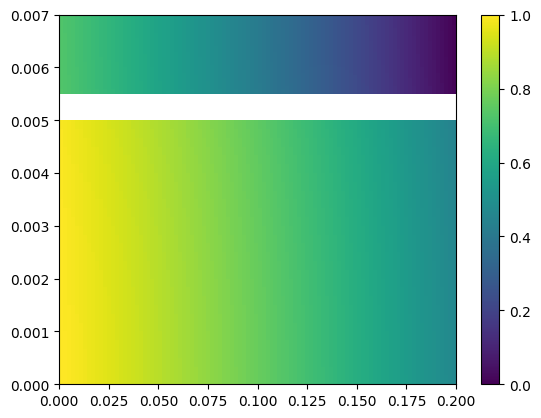

retentate side: inlet molar flow = 7.85398e-06, membrane molar flow out = 4.27200e-06, outlet molar flow = 3.58198e-06
retentate balance: 3.51519e-20
permeate side:  inlet molar flow = 0.00000e+00, membrane molar flow in  = 4.27200e-06, outlet molar flow = 4.27200e-06
permeate balance: -9.56463e-14
overall balance: 6.52794e-14


In [3]:
# Explicit coupling
from pymrm import compute_boundary_values
import copy

num_iter = 20  # Number of iterations for the explicit coupling
c_ret = np.zeros(shape_ret)
c_perm = np.zeros(shape_perm)
c_b_ret = np.zeros((num_z, 1))
c_b_perm = np.zeros((num_z, 1))

bc_mem_ret = {'a': D, 'b': P, 'd': P}
bc_r_ret = (bc_neumann, bc_mem_ret)
bc_mem_perm = {'a': R_perm/R_ret*D, 'b': P, 'd': P}
bc_r_perm = (bc_mem_perm, bc_neumann)

grad_ret_mat, _, grad_ret_bc = construct_grad(shape_ret, r_f_ret, r_c_ret, bc_r_ret, axis = 1, shapes_d = (None, shape_d))
grad_perm_mat, grad_perm_bc, _ = construct_grad(shape_perm, r_f_perm, r_c_perm, bc_r_perm, axis = 1, shapes_d = (shape_d, None))

jac_ret_mat = div_ret_mat_z @ conv_ret_mat - D*div_ret_mat_r @ grad_ret_mat
jac_ret_lu = sla.splu(jac_ret_mat)
jac_perm_mat = div_perm_mat_z @ conv_perm_mat - D*div_perm_mat_r @ grad_perm_mat
jac_perm_lu = sla.splu(jac_perm_mat)

rhs_ret_bc_const = -div_ret_mat_z @ conv_ret_bc
rhs_perm_bc_const = -div_perm_mat_z @ conv_perm_bc
jac_ret_bc = D*div_ret_mat_r @ grad_ret_bc
jac_perm_bc = D*div_perm_mat_r @ grad_perm_bc
bc_r_ret_interp = copy.deepcopy(bc_r_ret)
bc_r_perm_interp = copy.deepcopy(bc_r_perm)

for i in range(num_iter):
    bc_r_perm_interp[0]['d'] = bc_r_perm[0]['d']*c_b_ret
    c_b_perm, _, _, _ = compute_boundary_values(c_perm, r_f_perm, r_c_perm, bc_r_perm_interp, axis=1)
    rhs_ret_bc = rhs_ret_bc_const + jac_ret_bc @ c_b_perm.reshape(-1,1)
    c_ret[:]   = jac_ret_lu.solve(rhs_ret_bc).reshape(shape_ret)
    
    bc_r_ret_interp[1]['d'] = bc_r_ret[1]['d']*c_b_perm
    _, _, c_b_ret, _  = compute_boundary_values(c_ret, r_f_ret, r_c_ret, bc_r_ret_interp, axis=1)
    rhs_perm_bc= rhs_perm_bc_const +  jac_perm_bc @ c_b_ret.reshape(-1,1)
    c_perm[:]  = jac_perm_lu.solve(rhs_perm_bc).reshape(shape_perm)
    

plt.pcolormesh(z_f, r_f_ret, c_ret.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)
plt.pcolormesh(z_f, r_f_perm, c_perm.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)

plt.colorbar()
plt.show()

_, _, c_b_ret, _  = compute_boundary_values(c_ret, r_f_ret, r_c_ret, bc_r_ret_interp, axis=1)
c_b_perm, _, _, _ = compute_boundary_values(c_perm, r_f_perm, r_c_perm, bc_r_perm_interp, axis=1)
print_balances(c_ret, c_perm, c_b_ret, c_b_perm)

## Implicit Coupling

In this section, the retentate and permeate submodels are coupled implicitly. The coupling is achieved by solving a single system of equations that includes the interface conditions.

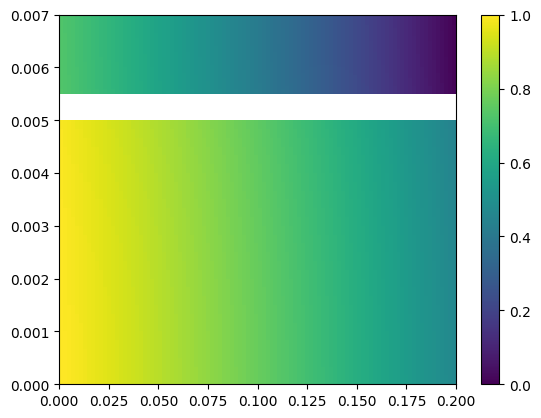

retentate side: inlet molar flow = 7.85398e-06, membrane molar flow out = 4.27200e-06, outlet molar flow = 3.58198e-06
retentate balance: -3.45166e-19
permeate side:  inlet molar flow = 0.00000e+00, membrane molar flow in  = 4.27200e-06, outlet molar flow = 4.27200e-06
permeate balance: -7.64363e-18
overall balance: -1.00873e-17


In [4]:
# Implicit coupling
c_all = np.zeros((num_z, num_r_ret + num_r_perm))
c_ret = c_all[:, :num_r_ret]
c_perm = c_all[:, num_r_ret:]
c_vect = c_all.reshape((-1,1))

shape_ret = c_ret.shape
shape_perm = c_perm.shape
shape_d = (num_z, 1)

# interface conditions:
ic_1 = {'a':(D,0), 'b':(P,-P), 'd':0}
ic_2 = {'a':(0,R_perm/R_ret*D), 'b':(-P,P), 'd':0}
interf_mat_ret, _, interf_mat_perm, _ = construct_interface_matrices((shape_ret, shape_perm), (r_f_ret, r_f_perm), ic=(ic_1, ic_2), axis=1)

grad_ret_mat_coupled, _, grad_ret_bc_coupled = construct_grad(shape_ret, r_f_ret, r_c_ret, bc = (bc_neumann, bc_dirichlet), axis = 1, shapes_d = (None, shape_d))
jac_ret_mat_coupled = div_ret_mat_z @ conv_ret_mat - D*div_ret_mat_r @ grad_ret_mat_coupled
rhs_ret_bc_coupled  = -div_ret_mat_z @ conv_ret_bc
rhs_ret_ic  = D*div_ret_mat_r @ grad_ret_bc_coupled
jac_ret_ic  = -D*div_ret_mat_r @ grad_ret_bc_coupled @ interf_mat_ret
jac_ret_mat_coupled = update_csc_array_indices(jac_ret_mat_coupled, shape_ret, c_all.shape, offset=None)
rhs_ret_ic = update_csc_array_indices(rhs_ret_ic, (shape_ret, None), (c_all.shape, None), offset=None)
jac_ret_ic = update_csc_array_indices(jac_ret_ic, (shape_ret, None), (c_all.shape, None), offset=None)
rhs_ret_bc_coupled = update_csc_array_indices(rhs_ret_bc_coupled, (shape_ret, None), (c_all.shape, None), offset=None)

grad_perm_mat_coupled, grad_perm_bc_coupled, _ = construct_grad(shape_perm, r_f_perm, r_c_perm, bc=(bc_dirichlet, bc_neumann), axis = 1, shapes_d = (shape_d, None))
jac_perm_mat_coupled = div_perm_mat_z @ conv_perm_mat - D*div_perm_mat_r @ grad_perm_mat_coupled
rhs_perm_bc_coupled  = -div_perm_mat_z @ conv_perm_bc*0
rhs_perm_ic  = D*div_perm_mat_r @ grad_perm_bc_coupled
jac_perm_ic  = -D*div_perm_mat_r @ grad_perm_bc_coupled @ interf_mat_perm
jac_perm_mat_coupled = update_csc_array_indices(jac_perm_mat_coupled, shape_perm, c_all.shape, offset=(0,shape_ret[1]))
rhs_perm_ic = update_csc_array_indices(rhs_perm_ic, (shape_perm, None), (c_all.shape, None), offset=((0,shape_ret[1]),None))
jac_perm_ic = update_csc_array_indices(jac_perm_ic, (shape_perm, None), (c_all.shape, None), offset=((0,shape_ret[1]),None))
rhs_perm_bc_coupled = update_csc_array_indices(rhs_perm_bc_coupled, (shape_perm, None), (c_all.shape, None), offset=((0,shape_ret[1]),None))

jac_coupled = jac_ret_mat_coupled + jac_perm_mat_coupled + jac_ret_ic + jac_perm_ic
jac_coupled_lu = sla.splu(jac_coupled)
rhs_coupled = rhs_ret_bc_coupled + rhs_perm_bc_coupled
rhs = rhs_coupled.toarray()

c_all[:] = jac_coupled_lu.solve(rhs).reshape(c_all.shape)
c_b_ret = interf_mat_ret @ c_vect
c_b_perm = interf_mat_perm @ c_vect

plt.pcolormesh(z_f, r_f_ret, c_ret.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)
plt.pcolormesh(z_f, r_f_perm, c_perm.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)
plt.colorbar()
plt.show()

c_b_ret = interf_mat_ret @ c_vect
c_b_perm = interf_mat_perm @ c_vect
print_balances(c_ret, c_perm, c_b_ret, c_b_perm)